In [5]:
import plotly.graph_objects as go # pip install plotly==4.9.0
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import sys
import queue
import itertools
from collections import deque

# Algorithm:
# 1. Break reads into kmers and create de Bruijn graph  
# 2. Remove tips (do DFS from respective nodes and delete found tips)
# 3. Remove leaves if any
# 4. Remove bubbles (do DFS and collect short disjoint paths, calculate weight, and remove accordingly) 
# 5. Find Euler cycle
# 6. Print circular genome


class Kmer_ID_Management:

    def __init__(self):
        self.id = 0
        self.MapTheID = {}
        self.kmers = {}

    def Insert(self, kmer):
        if kmer not in self.MapTheID:
            self.MapTheID[kmer] = self.id
            self.kmers[self.id] = kmer
            self.id += 1
#         print(self.MapTheID[kmer])
        return self.MapTheID[kmer]


class De_BruijnGraph(object):

    def __init__(self, k, reads):
        self.k = k
        self.threshold = self.k + 1
        self.kmer_ids = Kmer_ID_Management()
        self.coverage = {}
        self.graph = {}

        self.Outgoing_num = lambda k: len(self.graph[k][0])
        self.Incoming_num = lambda k: self.graph[k][1]

        self.Make_De_BruijnGraph(self.break_reads_into_kmers(reads))

    def break_reads_into_kmers(self, reads):
        break_read = lambda read: [ read[j:j + self.k] for j in range(len(read) - self.k + 1) ]
        return [ kmer for read in reads for kmer in break_read(read) ]

    def Make_De_BruijnGraph(self, kmers):

        def add_edge(graph, coverage, left, right):
            graph.setdefault(left, [set(), 0])
            graph.setdefault(right, [set(), 0])
            coverage.setdefault((left, right), 0)
            coverage[(left, right)] += 1

            if right not in graph[left][0]:
                graph[left][0].add(right)
                graph[right][1] += 1

        for kmer in kmers:
            left = self.kmer_ids.Insert(kmer[:-1])
            right = self.kmer_ids.Insert(kmer[1:])

            if left != right:
                add_edge(self.graph, self.coverage, left, right)

    def DeleteLeaves(self):
        removable = [ k for k, v in self.graph.items() if len(v[0]) == 0 ]
        for k in removable:
            del self.graph[k]

    def print_graph(self):
        for k, v in self.graph.items():
            print(k, v)


class TipRemoval(De_BruijnGraph):

    def __init__(self, k, reads):
        De_BruijnGraph.__init__(self, k, reads)

    def DeleteTips(self):
        for k, v in self.graph.items():
            findAndDelete = None

            if self.Outgoing_num(k) == 1 and self.Incoming_num(k) == 0:
                findAndDelete = self.findAndDelete_Incoming
            elif self.Outgoing_num(k) > 1:
                findAndDelete = self.findAndDelete_Outgoing
            else: continue

            condition = True
            while condition:
                condition = False
                for edge in v[0]:
                    if findAndDelete(edge, 0):
                        v[0].remove(edge)
                        condition = True
                        break

    def findAndDelete_Outgoing(self, current, depth):
        if self.Outgoing_num(current) > 1 or self.Incoming_num(current) > 1:
            return False

        if depth == self.threshold:
            return False

        if self.Outgoing_num(current) == 0:
            return True

        if self.findAndDelete_Outgoing(next(iter(self.graph[current][0])), depth + 1):
            to = next(iter(self.graph[current][0]))
            self.graph[current][0].pop()
            self.graph[to][1] -= 1
            return True

        return False

    def findAndDelete_Incoming(self, current, depth):
        if self.Outgoing_num(current) == 0 or self.Incoming_num(current) > 1:
            return True

        if depth == self.threshold:
            return False

        if self.findAndDelete_Incoming(next(iter(self.graph[current][0])), depth + 1):
            to = next(iter(self.graph[current][0]))
            self.graph[current][0].pop()
            self.graph[to][1] -= 1
            return True

        return False


class BubbleRemoval(TipRemoval):

    def __init__(self, k, reads):
        TipRemoval.__init__(self, k, reads)
        self.paths = {}

    def DeleteBubbles(self):
        for k, v in self.graph.items():
            if self.Outgoing_num(k) > 1:
                self.dfs(path=[k], current=k, depth=0)

        for pair, candidates_list in self.paths.items():
            source, target = pair[0], pair[1]
            best_path = max(candidates_list, key=lambda item: item[1])[0]
            for path, _ in candidates_list:
                if best_path == path or not self.bubbleispossible(source, target):
                    continue
                if self.paths_disjoint(best_path, path) and self.pathExists(path):
                    self.delete_path(path)

    def bubbleispossible(self, source, target):
        return len(self.graph[source][0]) > 1 and self.graph[target][1] > 1

    def pathExists(self, path):
        for j in range(len(path) -1):
            if path[j +1] not in self.graph[path[j]][0]:
                return False
        return True

    def delete_path(self, path):
        for j in range(len(path) -1):
            self.graph[path[j]][0].remove(path[j +1])
            self.graph[path[j +1]][1] -= 1
            del self.coverage[(path[j], path[j +1])]

    def paths_disjoint(self, a, b):
        return len(set(a) & set(b)) == 2  # only V and W are shared

    def dfs(self, path, current, depth):
        if current != path[0] and self.Incoming_num(current) > 1:
            weight = sum(self.coverage[(path[i], path[i+1])] for i in range(len(path)-1)) / len(path)
            self.paths.setdefault((path[0], current), list()).append((path[:], weight))

        if depth == self.threshold:
            return

        for next_ in self.graph[current][0]:
            if next_ not in path:
                path.append(next_)
                self.dfs(path, next_, depth + 1)
                path.remove(next_)


class GenomeAssembler(BubbleRemoval):

    def __init__(self, k, reads):
        BubbleRemoval.__init__(self, k, reads)

    def make_Euler_cycle(self):
        verteces = deque()
        path = []
        current = next(iter(self.graph))
        verteces.append(current)

        while verteces:
            current = verteces[0]
            if len(self.graph[current][0]) != 0:
                t = next(iter(self.graph[current][0]))
                verteces.append(t)
                self.graph[current][0].remove(t)
                continue
            path.append(current)
            verteces.popleft()

        return path

    def assemble(self):
        self.DeleteTips()
        self.DeleteLeaves()
        self.DeleteBubbles()

        cycle = self.make_Euler_cycle()
        circular_genome = self.kmer_ids.kmers[cycle[0]]
        for i in range(1, len(cycle) - (self.k - 1)):
            circular_genome += self.kmer_ids.kmers[cycle[i]][-1]

        return circular_genome
    
def de_bruijnize(st, k):
    edges = []
    nodes = set()
    not_starts = set()
    for i in range(len(st)-k+1):
        edges.append((st[i:i+k-1],st[i+1:i+k]))
        nodes.add(st[i:i+k-1])
        nodes.add(st[i+1:i+k])
        not_starts.add(st[i+1:i+k])
    return nodes,edges,list(nodes-not_starts)

def visual2D(st, k):
    G = nx.DiGraph(directed=True)

    nodes, edges= de_bruijnize(st, k)[0:2]
    for node in nodes:
        G.add_node(node)

    G.add_edges_from(edges)
    print("The nodes are: ",G.nodes)
    print("The edges are: ",G.edges)
    options = {
    'node_color': 'yellow',
    'node_size': 1000,
    'width': 2,
    'arrowstyle': '-|>',
    'arrowsize': 10,}

    pos=nx.spring_layout(G)
    nx.draw_networkx(G, arrows=True, **options)
    plt. show()


def visual3D(st, k):
    G = nx.DiGraph(directed=True)

    nodes, edges= de_bruijnize(st, k)[0:2]
    for node in nodes:
        G.add_node(node)

    G.add_edges_from(edges)
    Num_nodes = len(G.nodes)
    ## update to 3d dimension
    spring_3D = nx.spring_layout(G, dim = 3, k = 0.5) # k regulates the distance between nodes
    # we need to seperate the X,Y,Z coordinates for Plotly
    # NOTE: spring_3D is a dictionary where the keys are 1,...,6
    x_nodes= [spring_3D[key][0] for key in spring_3D.keys()] # x-coordinates of nodes
    y_nodes = [spring_3D[key][1] for key in spring_3D.keys()] # y-coordinates
    z_nodes = [spring_3D[key][2] for key in spring_3D.keys()] # z-coordinates

    #we need to create lists that contain the starting and ending coordinates of each edge.
    x_edges=[]
    y_edges=[]
    z_edges=[]

    #create lists holding midpoints that we will use to anchor text
    xtp = []
    ytp = []
    ztp = []

    #need to fill these with all of the coordinates
    for edge in G.edges():
        #format: [beginning,ending,None]
        x_coords = [spring_3D[edge[0]][0],spring_3D[edge[1]][0],None]
        x_edges += x_coords
        xtp.append(0.5*(spring_3D[edge[0]][0]+ spring_3D[edge[1]][0]))

        y_coords = [spring_3D[edge[0]][1],spring_3D[edge[1]][1],None]
        y_edges += y_coords
        ytp.append(0.5*(spring_3D[edge[0]][1]+ spring_3D[edge[1]][1]))

        z_coords = [spring_3D[edge[0]][2],spring_3D[edge[1]][2],None]
        z_edges += z_coords
        ztp.append(0.5*(spring_3D[edge[0]][2]+ spring_3D[edge[1]][2])) 
    #create a trace for the edges
    trace_edges = go.Scatter3d(
        x=x_edges,
        y=y_edges,
        z=z_edges,
        mode='lines',
        line=dict(color='black', width=2,),
        hoverinfo='none')

    #create a trace for the nodes
    trace_nodes = go.Scatter3d(
        x=x_nodes,
        y=y_nodes,
        z=z_nodes,
        mode='markers',
        text=list(G.nodes),
        marker=dict(symbol='circle',
                size=10,
                color='skyblue',)
        )

    #Include the traces we want to plot and create a figure
    data = [trace_edges, trace_nodes]
    fig = go.Figure(data=data)
    fig.show()



if __name__ == "__main__":
    read = input("Enter the genome:")
    reads= read.split() #to convert reads into a list
    k=int(input("Enter the value of k:"))
    print(reads)
    assembler = GenomeAssembler(k, reads)
#     print("The required assembled circular genome after removal of tips, leaves and bubbles:\n",assembler.assemble())

Enter the genome:ATGTTTTTAAGAAAACCCATATTAAATACTTCAACAGGCCGATGCGGTGCCATTGGTGTAATAAAAATTTCATTTGGTTATATAAATAAAAAAATATTATATTTTATATTTAAAAAAGTATTTTATAAAAAAATAAAAAATAAATTTATAAATTATTGTTTTATATATGATTATAAAAATTTTTTAATAGATAAAATTATTGTTTTATATTTTGAAAAACCTAATTCTTATACTGGTGAAGATATAATAGAATTACATTGTCATTGTAATAATTATATTTTAAAATTTATTATAGATAATTTTTTAAAAATTTTAAAAATATATGGAATAAGGTTATCCAAAAGAGGTGAATTCACAAAAAGAGGTTTTTTAAATAATAAAATAGATATTTTTGAATTAGAAATAATATCAAATATAATAAATTTTTATGGAAATTTTTTTTTAAAAAATATTGATATTAATTTAAAAAAAATTTTATTTTTCATATATAAGTTATCTAAAAATTTGATATTACAATTTGAAAATAAATTATTAAGTAATAAAAAAAATTTTTATTATTATTTAATATATATAAAAAATAAAATTTTTTTTGTTTTAAAAAATATAAAACTTTTTAAAAATAATAACAATTCTATTATAATTTTAGGCTTTTCTAATTCTGGTAAATCTACATTTATAAACAATTTTTCTTCAAACAATTTATCTATTATTAGTTCCACAAAGGGAACAACAAAGAATTTAATAAAAAAAATAGTAAATATAGATAATTTATTTTTTAAAATATTTGACACCCCTGGTGTTATAAATTTTAAAAATTCAATAGAATATTTAAATATTTTATTTGTAATAAAAAAAAAAAATTATTCAAAAATAATATTTTATATTTTTGATTCTTTTATTATTTATAATACATTTTTTTATTATATAAGAAAAAAAATTAAAAAACAACAAATAATAATTAATATATTAAATAAAATTGATAA

The nodes are:  ['GGA', 'ATA', 'AAG', 'GCT', 'TAT', 'TGC', 'CTC', 'TGT', 'GAC', 'GTA', 'GGG', 'CGT', 'GAA', 'TTA', 'GCC', 'ACG', 'TTC', 'AAA', 'CCA', 'TAC', 'ATT', 'ACT', 'GTC', 'GCG', 'GTG', 'CGC', 'CGA', 'AGG', 'GGC', 'CCT', 'GCA', 'ATG', 'CGG', 'AAC', 'TCT', 'AGA', 'TCG', 'CTT', 'AGT', 'ATC', 'GTT', 'TAG', 'TCC', 'TGG', 'TGA', 'TTG', 'ACC', 'GAT', 'CCC', 'CAC', 'CAA', 'CAG', 'TAA', 'CCG', 'GAG', 'AGC', 'CTA', 'CTG', 'TTT', 'CAT', 'ACA', 'GGT', 'TCA', 'AAT']
The edges are:  [('GGA', 'GAA'), ('GGA', 'GAC'), ('GGA', 'GAG'), ('GGA', 'GAT'), ('ATA', 'TAT'), ('ATA', 'TAC'), ('ATA', 'TAA'), ('ATA', 'TAG'), ('AAG', 'AGA'), ('AAG', 'AGT'), ('AAG', 'AGG'), ('AAG', 'AGC'), ('GCT', 'CTT'), ('GCT', 'CTA'), ('GCT', 'CTC'), ('GCT', 'CTG'), ('TAT', 'ATT'), ('TAT', 'ATA'), ('TAT', 'ATG'), ('TAT', 'ATC'), ('TGC', 'GCG'), ('TGC', 'GCC'), ('TGC', 'GCA'), ('TGC', 'GCT'), ('CTC', 'TCT'), ('CTC', 'TCG'), ('CTC', 'TCC'), ('CTC', 'TCA'), ('TGT', 'GTT'), ('TGT', 'GTA'), ('TGT', 'GTC'), ('TGT', 'GTG'), ('GAC'

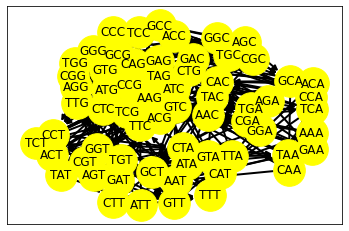

In [6]:
visual2D(read, k)

In [8]:
visual3D(read, k)

In [9]:
assembler = GenomeAssembler(k, reads)
print("The required assembled circular genome after removal of tips, leaves and bubbles:\n",assembler.assemble())

The required assembled circular genome after removal of tips, leaves and bubbles:
 ATG
